In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def fourier_series(x, *a): 
    degree = (len(a)-1)/2
    ret = a[-1]
    for deg in range(int(degree)):
        ret += a[deg*2] * np.cos((deg+1)*2*np.pi * x + a[1 + deg*2])
    return ret

def fourierfit(phase, mag, mag_err, degree):
    #initialize array of coefficients (A0, phi0, A1, phi1..., offset)
    a_init=[1.0,.1] * degree + [np.mean(mag)]
    
    popt, pcov = curve_fit(fourier_series, phase, mag, a_init, sigma = mag_err, maxfev=20000)
    return popt

In [3]:
def fourier_decomposition(phase, mag, mag_err):
    '''
    Finding Fourier parameters and degree of fitting
    '''
    n = len(phase)
    df = pd.DataFrame({'Phase': phase, 'Magnitude': mag, 'Error': mag_err})
    df = df.sort_values(by='Phase').reset_index(drop = True)

    degree = 1
    rho = 1/(np.sqrt(2*(n-1))) + 1
    
    while rho > 1/(np.sqrt(2*(n-1))):
        coef = fourierfit(df['Phase'], df['Magnitude'], df['Error'], degree)
        mag_model = [fourier_series(t,*coef) for t in df['Phase']]
        err_model = np.sum((df['Magnitude'] - mag_model)**2)/(np.sqrt(n-1))
        v = df['Magnitude'] - mag_model
        v = np.array(v)
        mean_v = np.nanmean(v)
        rho = 0
        for i in range(-1,n-1):
            rho += (v[i] - mean_v)*(v[i+1] - mean_v)

        rho = rho/np.sum((v - mean_v)**2)
        degree += 1
        
    return coef, degree - 1, err_model

In [4]:
def mean_mag(mag):
    '''
    Calculating mean magnitude
    '''
    mag = np.array(mag)
    n = len(mag)
    I = 10**(-0.4*mag)
    mean_I = (I[0] + I[-1])/2
    for i in range(1,n-1):
        mean_I += I[i]/n
    return -2.5*np.log10(mean_I)

In [5]:
def mag_band(lightcurve, band, period):
    '''
    Calculating mean magnitude of each GAIA band and its errors
    '''
    if band =='g':
        band = 'gTransit'
        obstime = band+'Time'
    else:
        obstime = band + 'ObsTime'

    cepheid_cleaned = lightcurve.dropna(subset = [obstime]).reset_index(drop = True)
    mag = cepheid_cleaned[band+'Mag']
    mag_med = mag.median()
    mag_std = mag.std()
    cepheid_cleaned = cepheid_cleaned[abs(cepheid_cleaned[band+'Mag'] - mag_med) < 2.5*mag_std].reset_index(drop = True)

    mag = cepheid_cleaned[band+'Mag']
    mag_err = 2.5/(np.log(10)*cepheid_cleaned[band+'FluxOverError'])
    
    phase = ((cepheid_cleaned[obstime] - cepheid_cleaned[obstime].iloc[0])/period)%1
    coef, degree, error = fourier_decomposition(phase, mag, mag_err)
    mag_model = [fourier_series(t,*coef) for t in phase]
    return mean_mag(mag_model), error

In [6]:
def run(data, lightcurve_folder, n_samples = 300, mode = 'FUNDAMENTAL'):
    '''
    Mode can be 'FUNDAMENTAL' (default) or 'FIRST_OVERTONE'
    '''
    data_mode = data.loc[data.variCepheid_modeBestClassification == mode].reset_index(drop = True)

    band = ['g','bp','rp']
    mag_g = []
    err_g = []
    mag_bp = []
    err_bp = []
    mag_rp = []
    err_rp = []
    P = []
    P_err = []

    sample = data_mode['variCepheid_sourceId'].sample(n_samples, replace=False).tolist()
    for i, ID in enumerate(sample):
        if mode == 'FUNDAMENTAL':
            period = data_mode['variCepheid_pf'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
            period_err = data_mode['variCepheid_pfError'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
        else:
            period = data_mode['variCepheid_p1O'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
            period_err = data_mode['variCepheid_p1Oerror'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
        P.append(period)
        P_err.append(period_err)
        
        path = lightcurve_folder + str(ID)+'_epochPhotFile.csv'
        lightcurve = pd.read_csv(path, skiprows = 3)
        try:
            mag_value = []
            err_value = []
            for Band in band:
                mag, err = mag_band(lightcurve, Band, period)
                mag_value.append(mag)
                err_value.append(err)
            mag_g.append(mag_value[0])
            mag_bp.append(mag_value[1])
            mag_rp.append(mag_value[2])
            err_g.append(err_value[0])
            err_bp.append(err_value[1])
            err_rp.append(err_value[2])
        except (IndexError, TypeError, RuntimeError):
            print(ID)
            P = P[:-1]
            P_err = P[:-1]

    mag_g = np.array(mag_g)
    mag_bp = np.array(mag_bp)
    mag_rp = np.array(mag_rp)
    err_g = np.array(err_g)
    err_rp = np.array(err_rp)
    err_bp = np.array(err_bp)
    P = np.array(P)
    P_err = np.array(P_err)

    w = mag_g - 1.9*(mag_bp - mag_rp)
    w_err = np.sqrt(err_g**2 + 1.9*(err_bp**2 + err_rp**2))

    return w, w_err, P, P_err

In [7]:
def DM_calculator(w, w_err, W, W_err):
    '''
    Distance modulus calculator
    '''
    DM = w - W
    DM_err = np.sqrt(w_err**2 + W**2)
    d = 10**((DM+5)/5)
    std_d = 10**((DM_err+5)/5)
    sigma_d = np.log(10)*std_d*d/5
    weight = 1/sigma_d**2
    mean_d = np.sum(d*weight)/np.sum(weight)
    n = len(d)
    sigma_mean_d = np.sqrt(np.sum(weight*(d - mean_d)**2)/(np.sum(weight)*(n-1)))
    mean_DM = 5*np.log10(mean_d) - 5
    std_DM = 5*np.log10(np.e)*sigma_mean_d/mean_d

    return mean_d, sigma_mean_d, mean_DM, std_DM

In [8]:
def plot_lightcurve(data, lightcurve_folder, ind, band):
    '''
    data: general csv file
    ind: list of IDs
    band: 'g', 'bp', 'rp'
    '''
    fig, ax = plt.subplots(1,len(ind), figsize = (15,5), sharex = True)
    fig.supxlabel('Phase')
    fig.supylabel(f'Magnitude ({band})')

    if band =='g':
        band = 'gTransit'
        obstime = band+'Time'
    else:
        obstime = band + 'ObsTime'
    for i,ID in enumerate(ind):
        mode = data['variCepheid_modeBestClassification'][data['variCepheid_sourceId'] == ID].iloc[0]
        print(mode)
        data_mode = data.loc[data.variCepheid_modeBestClassification == str(mode)].reset_index(drop = True)
        if mode == 'FUNDAMENTAL':
            period = data_mode['variCepheid_pf'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
            mode_short = 'FU'
        else:
            period = data_mode['variCepheid_p1O'][data_mode['variCepheid_sourceId'] == ID].iloc[0]
            mode_short = 'FO'
    
        path = lightcurve_folder + str(ID) +'_epochPhotFile.csv'
        lightcurve = pd.read_csv(path, skiprows = 3)
    
        # if band =='g':
        #     band = 'gTransit'
        #     obstime = band+'Time'
        # else:
        #     obstime = band + 'ObsTime'
        cepheid_cleaned = lightcurve.dropna(subset = [obstime]).reset_index(drop = True)
        mag = cepheid_cleaned[band+'Mag']
        mag_med = mag.median()
        mag_std = mag.std()
        cepheid_cleaned = cepheid_cleaned[abs(cepheid_cleaned[band+'Mag'] - mag_med) < 2.5*mag_std].reset_index(drop = True)
    
        mag = cepheid_cleaned[band+'Mag']
        mag_err = 2.5/(np.log(10)*cepheid_cleaned[band+'FluxOverError'])
        
        phase = ((cepheid_cleaned[obstime] - cepheid_cleaned[obstime].iloc[0])/period)%1
        coef, degree, error = fourier_decomposition(phase, mag, mag_err)
        print(degree, error, len(mag))
       
        p = np.arange(0,2+0.01,0.01)
        # plt.figure(figsize = (5,6))
        # ax[i].scatter([phase, phase + 1], [mag, mag], s = 20, color = 'black',label = 'Observations')
        x = np.concatenate([phase, phase + 1])
        y = np.concatenate([mag,mag])
        ax[i].errorbar(x, y, yerr = np.concatenate([mag_err, mag_err]), fmt = '.', color = 'black', capsize=5, markersize=5)
        ax[i].plot(p, [fourier_series(t,*coef) for t in p],'r--', label = 'Fourier model')
        ax[i].text(0, min(mag) - 1.5*(max(mag) - min(mag))/10, f'ID = {ID} ({mode_short})\n P = {np.round(period,6)} d', fontsize=10, fontweight='bold')
        ax[i].set_ylim([min(mag) - 1.5*(max(mag) - min(mag))/10, max(mag) + (max(mag) - min(mag))/10])
        ax[i].invert_yaxis()
        # ax[i].set_xlabel('Phase')
        # ax[i].set_ylabel(f'Magnitude ({band})')
        ax[i].tick_params(axis='both', which='major', direction='in', top=True, bottom=True, left=True, right=True)
        ax[i].tick_params(axis='both', which='minor', direction='in', top=True, bottom=True, left=True, right=True)


    plt.tight_layout()

# Test

In [102]:
import os

working_dir = '/home/tinmai/Desktop/Modern Astro'
os.chdir(working_dir)
os.getcwd()

pd.set_option('display.max_rows', 10)

In [21]:
# data = pd.read_csv('data.csv')
# fundamental = data.loc[data.variCepheid_modeBestClassification == 'FUNDAMENTAL'].reset_index(drop = True)

In [22]:
# ID = 4657968208177682432
# path = 'Data/' + str(ID) +'_epochPhotFile.csv'
# cepheid = pd.read_csv(path, skiprows = 3)
# cepheid_cleaned = cepheid.dropna(subset = ['bpObsTime']).reset_index(drop = True)
# bp_mag_med = cepheid_cleaned['bpMag'].median()
# bp_mag_std = cepheid_cleaned['bpMag'].std()
# cepheid_cleaned = cepheid_cleaned[abs(cepheid_cleaned['bpMag'] - bp_mag_med) < 3*bp_mag_std].reset_index(drop = True)
# period = fundamental['variCepheid_pf'][fundamental['variCepheid_sourceId'] == ID].iloc[0]
# phase = ((cepheid_cleaned['bpObsTime'] - cepheid_cleaned['bpObsTime'].iloc[0])/period)%1
# mag = cepheid_cleaned['bpMag']
# mag_err = 2.5/(np.log(10)*cepheid_cleaned['bpFluxOverError'])
# coef, degree, error = fourier_decomposition(phase, mag, mag_err)

# p = np.arange(0,2+0.01,0.01)

# mode = 'FU'
# plt.figure(figsize = (5,6))
# # plt.scatter([phase, phase + 1], [mag, mag], s = 20, color = 'black',label = 'Observations')
# plt.errorbar(phase, y = mag, yerr=mag_err, fmt = '.', color = 'black', capsize=5, markersize=5)
# plt.plot(p, [fourier_series(t,*coef) for t in p],'r--', label = 'Fourier model')
# plt.text(0, min(mag) - 0.01, f'ID = {ID} ({mode})\n P = {np.round(period,6)} d', fontsize=13, fontweight='bold')
# plt.ylim([min(mag) - 1.5*(max(mag) - min(mag))/10, max(mag) + 0.01])
# plt.gca().invert_yaxis()
# plt.xlabel('Phase')
# plt.ylabel('Magnitude')
# plt.tick_params(axis='both', which='major', direction='in', top=True, bottom=True, left=True, right=True)
# plt.tick_params(axis='both', which='minor', direction='in', top=True, bottom=True, left=True, right=True)


In [19]:
data = pd.read_csv('data_big.csv')
lightcurve_path = 'Data_big/'
count = data['variCepheid_modeBestClassification'].value_counts()
count['FIRST_OVERTONE']

(201, 540)

## Fitting

In [10]:
first_o = data.loc[data.variCepheid_modeBestClassification == 'FIRST_OVERTONE'].reset_index(drop = True)
fundamental = data.loc[data.variCepheid_modeBestClassification == 'FUNDAMENTAL'].reset_index(drop = True)

FUNDAMENTAL
4 0.00059725517044922 36
FUNDAMENTAL
4 6.32577661254275e-05 36
FUNDAMENTAL
2 0.043935457418190105 42
FUNDAMENTAL
4 0.00033807582010193625 40
FIRST_OVERTONE
1 0.0025224146597436115 30
FIRST_OVERTONE
1 0.018561127176196877 38
FIRST_OVERTONE
2 0.0010521935961608352 34
FIRST_OVERTONE
2 0.012496666347870332 45


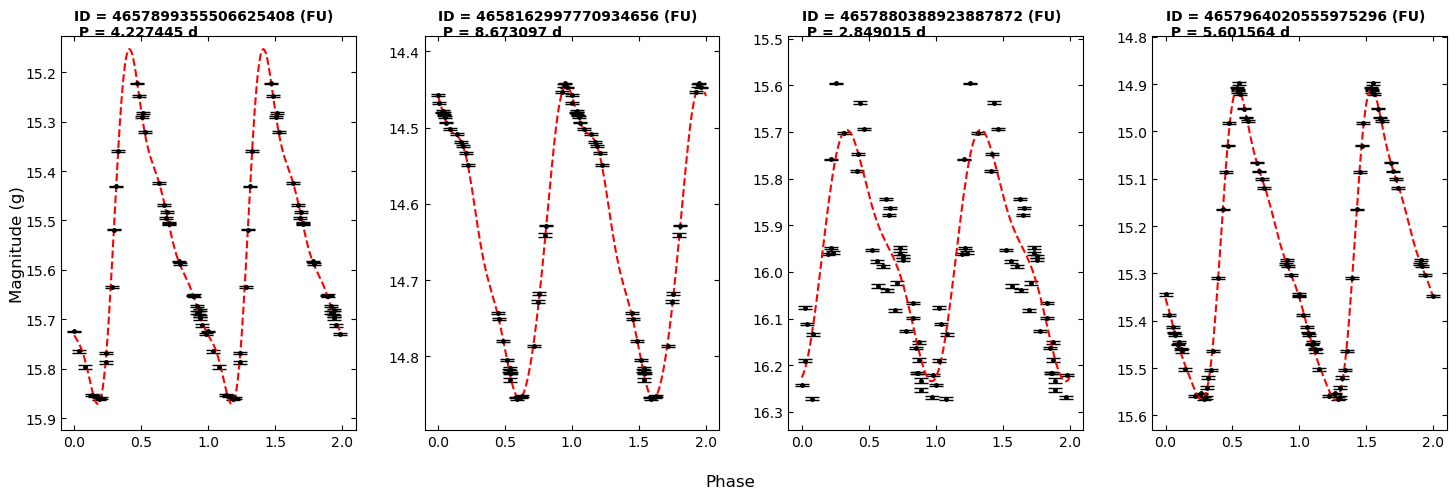

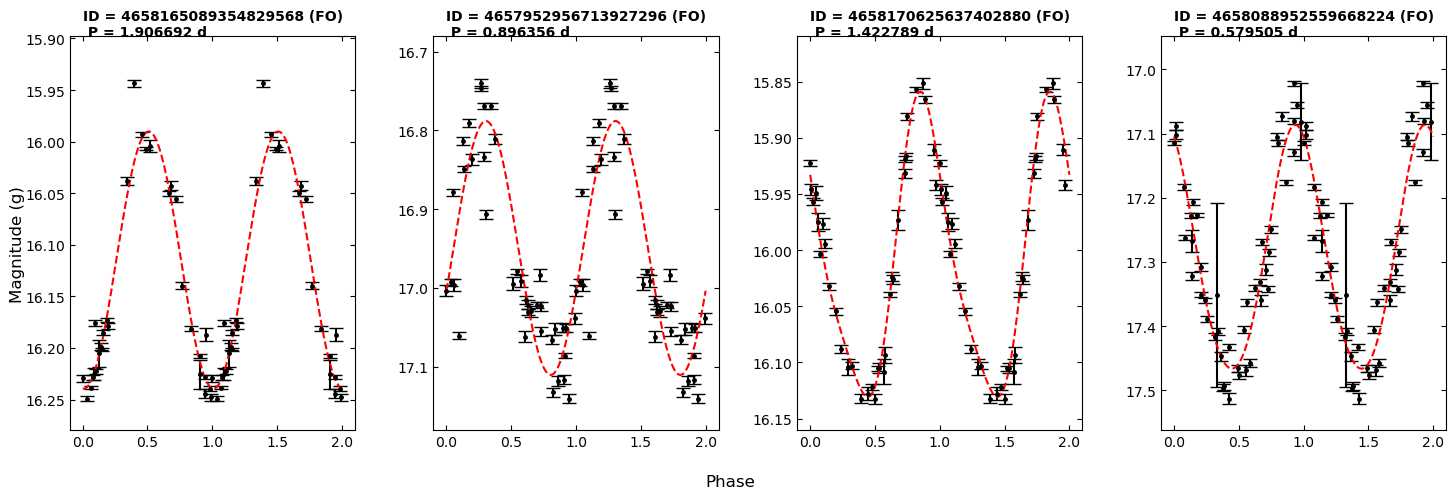

In [11]:
# ind = fundamental['variCepheid_sourceId'].sample(6, replace=False).tolist()
ind = fundamental['variCepheid_sourceId'].sample(4, replace=False).tolist()
plot_lightcurve(data, lightcurve_path, ind, 'g')
ind = first_o['variCepheid_sourceId'].sample(4, replace=False).tolist()
plot_lightcurve(data, lightcurve_path, ind, 'g')

## Distance

In [12]:
mode = 'FUNDAMENTAL'
w, w_err, P, P_err = run(data, lightcurve_path, n_samples = count[mode], mode = mode)

4657951376166382080
4657966838009297536


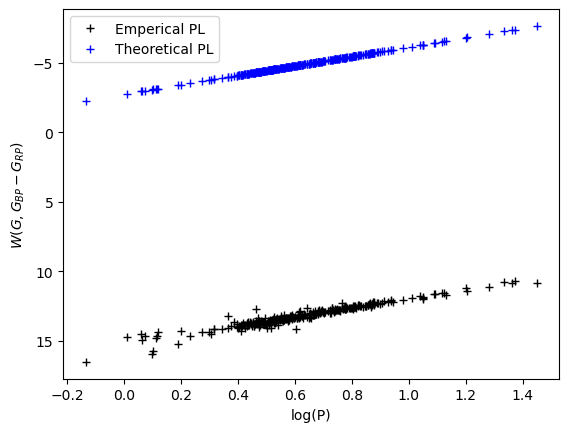

In [13]:
W = -2.744 - 3.391*np.log10(P)
W_err = np.sqrt(0.045**2 + (0.052*P_err)**2)
plt.plot(np.log10(P),w, color='black', marker='+', linewidth = 0, label = 'Emperical PL')
plt.plot(np.log10(P),W,'b+', label = 'Theoretical PL')
plt.gca().invert_yaxis()
plt.xlabel('log(P)')
plt.ylabel(r'$W(G, G_{BP} - G_{RP})$')
plt.legend()

In [14]:
DM_calculator(w, w_err, W, W_err)

(39945.856030854986, 288.4032293267252, 18.00735866214493, 0.01567771272230688)

In [15]:
mode = 'FIRST_OVERTONE'
w, w_err, P, P_err = run(data, lightcurve_path, n_samples = count[mode], mode = 'FIRST_OVERTONE')
W = -3.224 - 3.588*np.log10(P)
W_err = np.sqrt(0.028**2 + (0.065*P_err)**2)
DM_calculator(w, w_err, W, W_err)

(37992.86729205272, 282.0202597906291, 17.89851035328641, 0.016118794308216357)

In [31]:
w_f, w_f_err, P_f, P_f_err = run(data, lightcurve_path, n_samples = count['FUNDAMENTAL'], mode = 'FUNDAMENTAL')
w_o, w_o_err, P_o, P_o_err = run(data, lightcurve_path, n_samples =,count['FIRST_OVERTONE'] mode = 'FIRST_OVERTONE')

4657951376166382080 bp
4657951376166382080 rp
4657966838009297536 bp
4657966838009297536 rp


In [120]:
fund = pd.DataFrame({'W': w_f, 'P': P_f, 'Type': 'FU'})
over = pd.DataFrame({'W': w_o, 'P': P_o, 'Type': 'FO'})
last = pd.concat([fund, over], ignore_index=True)

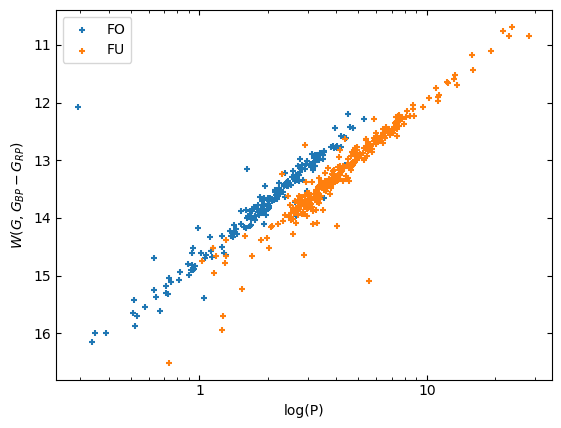

In [146]:
import matplotlib.ticker as ticker

for data_type, group in last.groupby('Type'):
    plt.scatter(group['P'], group['W'], marker = '+', s = 20, label=data_type)

plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.f'))
plt.gca().invert_yaxis()
plt.xlabel('log(P)')
plt.ylabel(r'$W(G, G_{BP} - G_{RP})$')
plt.tick_params(axis='both', which='major', direction='in', top=True, bottom=True, left=True, right=True)
plt.tick_params(axis='both', which='minor', direction='in', top=True, bottom=True, left=True, right=True)

Text(0, 0.5, 'DEC')

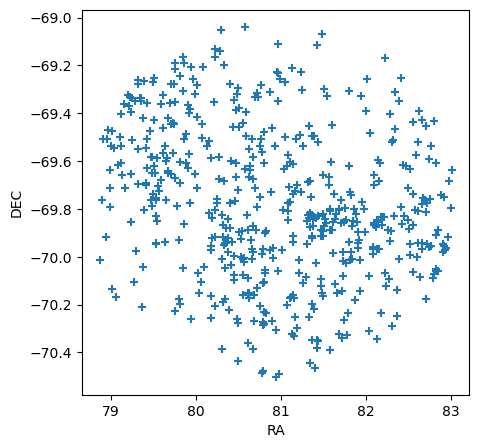

In [26]:
from astropy.coordinates import SkyCoord
from astropy import units as u

sample = data.sample(count.sum(), replace=False)

ra_center = 0 *u.deg
dec_center = 0 *u.deg
ra = np.array(sample['gaiaSource_ra'])* u.deg
dec = np.array(sample['gaiaSource_decl']) * u.deg

coords = SkyCoord(ra=ra, dec=dec, frame='icrs')
center_coords = SkyCoord(ra=ra_center, dec=dec_center, frame='icrs')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111) 

ra_offset = (coords.ra - center_coords.ra)
dec_offset = (coords.dec - center_coords.dec)

ax.scatter(ra_offset, dec_offset, marker ='+')
# ax.set_xlim([0, 30])
# ax.set_ylim([-10, 10])

ax.set_xlabel('RA')
ax.set_ylabel('DEC')
